In [1]:
import sys
import os
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import numpy as np
from matplotlib import cm
from matplotlib.colors import BoundaryNorm

sys.path.append("..")

from magnetic_isolation.solutions import theta_values, u_values, delta, theta_edo

base_folder = os.path.join(".", "Plots_saved", "Params_analysis")
os.makedirs(base_folder, exist_ok=True)

# Patterns search

We will plot in the 2D plane with the different $\hat{k}$ and $\hat{\beta}$ values in order to see if there exists any kind of bpundary where the amount of solutions increases or dicreases... And even more important, in which pairs there is no solution

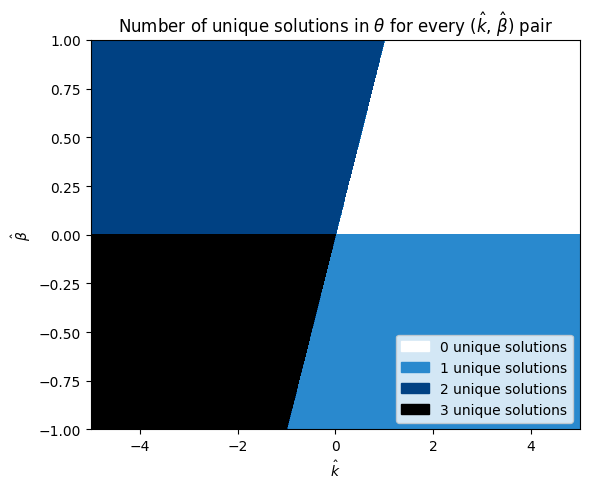

In [2]:
count_unique = lambda k, b: len(np.unique(theta_values(k, b)))

min_k, max_k = -5, 5
min_b, max_b = -1, 1
n_points = 1000

k = np.linspace(min_k, max_k, n_points)
b = np.linspace(min_b, max_b, n_points)
K, B = np.meshgrid(k, b)
Z = np.vectorize(count_unique)(K, B)

levels = np.arange(-1, 5)
colors = ["#FFFFFF", "#2989ce", "#004183", "#000000"] 

plt.figure(figsize=(6, 5))
contour = plt.contourf(K, B, Z, levels=levels, colors=colors, extend='both')

legend_labels = [str(i) for i in range(4)]
legend_patches = [Patch(color=color, label=f'{label} unique solutions') for color, label in zip(colors, legend_labels)]

plt.legend(handles=legend_patches, loc='lower right')

plt.xlabel('$\\hat{k}$')
plt.ylabel('$\\hat{\\beta}$')
plt.title('Number of unique solutions in $\\theta$ for every ($\\hat{k}$, $\\hat{\\beta}$) pair')
plt.tight_layout()
plt.show()

We can see there is a linear boundary between having a solution and not having them, then we can say that there is a relationship between the parameters and the existing solutions!

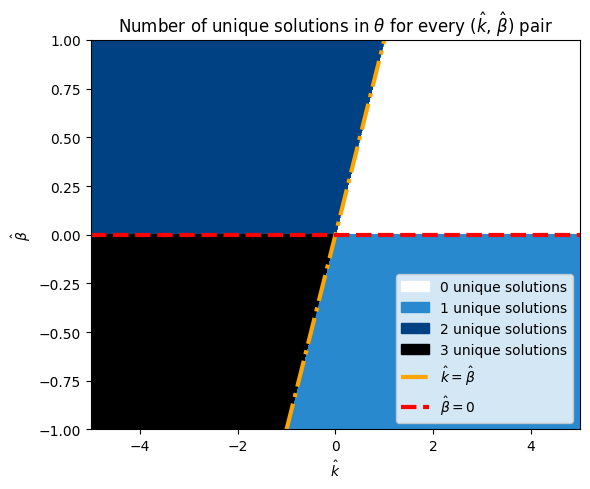

In [3]:
count_unique = lambda k, b: len(np.unique(theta_values(k, b)))

min_k, max_k = -5, 5
min_b, max_b = -1, 1
n_points = 1000

k = np.linspace(min_k, max_k, n_points)
b = np.linspace(min_b, max_b, n_points)
K, B = np.meshgrid(k, b)
Z = np.vectorize(count_unique)(K, B)

levels = np.arange(-1, 5)
colors = ["#FFFFFF", "#2989ce", "#004183", "#000000"] 

plt.figure(figsize=(6, 5))
contour = plt.contourf(K, B, Z, levels=levels, colors=colors, extend='both')

plot_min_k = max(min_k, min_b)
plot_max_k = min(max_k, max_b)
line1, = plt.plot([plot_min_k, plot_max_k], [plot_min_k, plot_max_k], color='orange', linestyle='-.', linewidth=3, label=r"$\hat{k} = \hat{\beta}$")
line2, = plt.plot([min_k, max_k], [0, 0], color='red', linestyle='--', linewidth=3,
                  label='$\\hat{\\beta} = 0$')

legend_labels = [str(i) for i in range(4)]
legend_patches = [Patch(color=color, label=f'{label} unique solutions') for color, label in zip(colors, legend_labels)]

# Combine handles for full legend
all_handles = legend_patches + [line1, line2]
plt.legend(handles=all_handles, loc='lower right')

plt.xlabel('$\\hat{k}$')
plt.ylabel('$\\hat{\\beta}$')
plt.title('Number of unique solutions in $\\theta$ for every ($\\hat{k}$, $\\hat{\\beta}$) pair')
plt.tight_layout()
plt.show()

# Discriminant Analysis

We will plot the areas where $\Delta u$ is lower, equal and higher to zero

The following is the sceenario where $\Delta u = 0$:

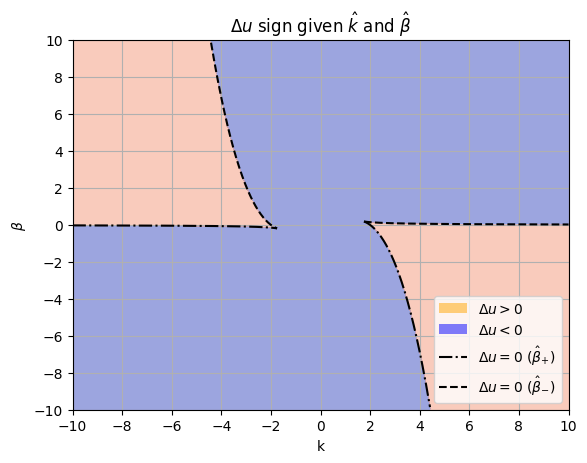

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# ---------- helpers ----------
def tolerant_sign(x, tol=1e-8):
    """Sign with tolerance: returns 0 if |x| <= tol."""
    if np.isscalar(x):
        return 0 if abs(x) <= tol else np.sign(x)
    else:
        x = np.asarray(x)
        near_zero = np.abs(x) <= tol
        result = np.sign(x)
        result[near_zero] = 0
        return result

def split_on_nan(x, y):
    """
    Split (x, y) into contiguous chunks where y is not NaN.
    Returns a list of (x_chunk, y_chunk).
    """
    isnan = np.isnan(y)
    segments = []
    start = None
    for i in range(len(y)):
        if not isnan[i]:
            if start is None:
                start = i
        else:
            if start is not None:
                segments.append((x[start:i], y[start:i]))
                start = None
    if start is not None:
        segments.append((x[start:], y[start:]))
    return segments

delta_sign = lambda k, b: tolerant_sign(delta(k, b), tol=1e-6)

def beta_from_k_plus(k):
    with np.errstate(invalid="ignore"):
        return (-18*k + 4*k**3 + np.sqrt((18*k - 4*k**3)**2 + 4*(k**2 - 4)*27)) / (-54)

def beta_from_k_minus(k):
    with np.errstate(invalid="ignore"):
        return (-18*k + 4*k**3 - np.sqrt((18*k - 4*k**3)**2 + 4*(k**2 - 4)*27)) / (-54)

# ---------- grid setup ----------
min_k, max_k = -10, 10
min_b, max_b = -10, 10
n_points = 1000

k = np.linspace(min_k, max_k, n_points)
b = np.linspace(min_b, max_b, n_points)
K, B = np.meshgrid(k, b)

# Compute sign of delta
Z = np.vectorize(delta_sign)(K, B)

# ---------- plotting ----------
cont = plt.contourf(K, B, Z, levels=[-1, 0, 1], cmap='coolwarm', alpha=0.5, extend='both')

# Compute beta(k) curves
beta_s_plus = beta_from_k_plus(k)
beta_s_minus = beta_from_k_minus(k)

# Split into contiguous NaN-free chunks and plot
segments_plus = split_on_nan(k, beta_s_plus)
segments_minus = split_on_nan(k, beta_s_minus)

for i, (x_seg, y_seg) in enumerate(segments_plus):
    mask = (y_seg >= min_b) & (y_seg <= max_b)
    plt.plot(x_seg[mask], y_seg[mask],
             color='black', linestyle='-.',
             label=r"$\Delta u = 0$ $(\hat{\beta}_{+})$" if i == 0 else "")

for i, (x_seg, y_seg) in enumerate(segments_minus):
    mask = (y_seg >= min_b) & (y_seg <= max_b)
    plt.plot(x_seg[mask], y_seg[mask],
             color='black', linestyle='--',
             label=r"$\Delta u = 0$ $(\hat{\beta}_{-})$" if i == 0 else "")

# ---------- legend ----------
legend_elements = [
    Patch(facecolor='orange', alpha=0.5, label=r'$\Delta u > 0$'),
    Patch(facecolor='blue', alpha=0.5, label=r'$\Delta u < 0$'),
]

plt.legend(handles=legend_elements + plt.gca().get_legend_handles_labels()[0], loc='lower right')

# ---------- axis settings ----------
plt.xticks(np.arange(min_k, max_k + 1, 2))
plt.yticks(np.arange(min_b, max_b + 1, 2))
plt.xlabel("k")
plt.ylabel(r"$\beta$")
plt.title(r"$\Delta u$ sign given $\hat{k}$ and $\hat{\beta}$")
plt.grid(True)
plt.savefig(os.path.join(base_folder, "Delta_u_sign_vs_k_beta.png"), dpi=300)
plt.show()


Now we will focus in plotting the scenarios given in $\Delta_u < 0$

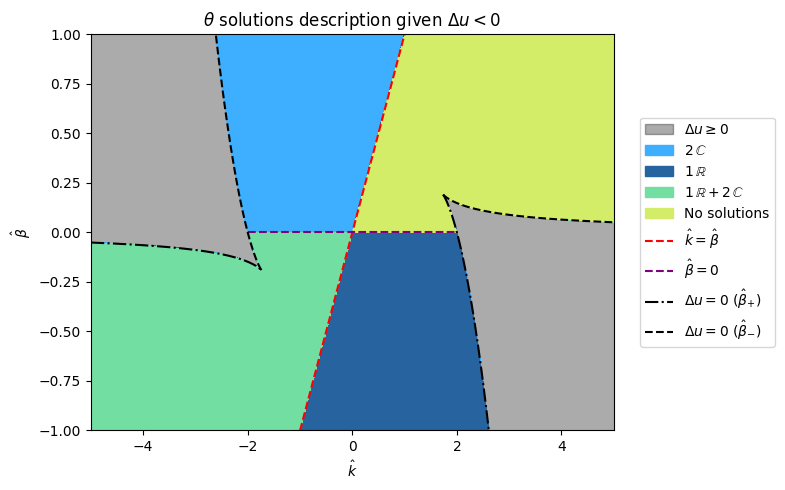

In [5]:
def deltau_lower_0(k,b):
    '''
    0 --> delta >= 0
    1 --> Only Two Complex solutions
    2 --> Only One Real solution
    3 --> One Real and Two Complex solutions
    4 --> Not solutions
    '''
    d = delta(k, b)
    if d >= 0: return 0
    thetas = theta_values(k, b)
    if len(thetas) == 0: return 4
    has_real = False
    has_complex = False
    for theta in thetas:
        if np.imag(theta) == 0:
            has_real = True
        else:
            has_complex = True
    if has_real and not has_complex:
        return 2
    if has_complex and not has_real:
        return 1
    if has_real and has_complex:
        return 3

min_k, max_k = -5, 5
min_b, max_b = -1, 1
n_points = 1000

k = np.linspace(min_k, max_k, n_points)
b = np.linspace(min_b, max_b, n_points)
K, B = np.meshgrid(k, b)
Z = np.vectorize(deltau_lower_0)(K, B)
levels = [-0.5, 0.5, 1.5, 2.5, 3.5, 4.5]
colors = ["#00000054", "#3eaeff", "#27639E", "#73DEA2", "#D4ED68"] 

norm = BoundaryNorm(levels, len(colors))

plt.figure(figsize=(8, 5))
contour = plt.contourf(K, B, Z, levels=levels, colors=colors, norm=norm, extend='both')
root = 2
plot_min_k = max(min_k, min_b)
plot_max_k = min(max_k, max_b)
line1, = plt.plot([plot_min_k, plot_max_k], [plot_min_k, plot_max_k], color='red', linestyle='--', label=r"$\hat{k} = \hat{\beta}$")
line2, = plt.plot([-root, root], [0, 0], color="purple", linestyle='--', label=r"$\hat{\beta} = 0$")

# Compute beta(k) curves
beta_s_plus = beta_from_k_plus(k)
beta_s_minus = beta_from_k_minus(k)

# Split into contiguous NaN-free chunks and plot
segments_plus = split_on_nan(k, beta_s_plus)
segments_minus = split_on_nan(k, beta_s_minus)

legend_curves = [line1,line2]

for i, (x_seg, y_seg) in enumerate(segments_plus):
    mask = (y_seg >= min_b) & (y_seg <= max_b)
    l, =plt.plot(x_seg[mask], y_seg[mask],
             color='black', linestyle='-.',
             label=r"$\Delta u = 0$ $(\hat{\beta}_{+})$" if i == 0 else "")
    if i==0: legend_curves.append(l)

for i, (x_seg, y_seg) in enumerate(segments_minus):
    mask = (y_seg >= min_b) & (y_seg <= max_b)
    l, = plt.plot(x_seg[mask], y_seg[mask],
             color='black', linestyle='--',
             label=r"$\Delta u = 0$ $(\hat{\beta}_{-})$" if i == 0 else "")
    if i==0: legend_curves.append(l)

legend_labels = [r"$\Delta u \geq 0$",
                 r"$2\, \mathbb{C}$",                    # Two complex solutions
                 r"$1\, \mathbb{R}$",                    # One real solution
                 r"$1\, \mathbb{R} + 2\, \mathbb{C}$",   # One real + two complex
                 "No solutions"]    
    
legend_patches = [Patch(color=color, label=label) for color, label in zip(colors, legend_labels)] + legend_curves

plt.legend(handles=legend_patches,
           loc='center left',
           bbox_to_anchor=(1.05, 0.5),
           borderaxespad=0.)

plt.xlabel('$\\hat{k}$')
plt.ylabel('$\\hat{\\beta}$')
plt.title(r'$\theta$ solutions description given $\Delta u < 0$')
plt.tight_layout()
plt.savefig(os.path.join(base_folder, "Theta_solutions_description_Deltau_lower_0_vs_k_beta.png"), dpi=300)
plt.show()

Now we will focus in the scenario where $\Delta_u > 0$

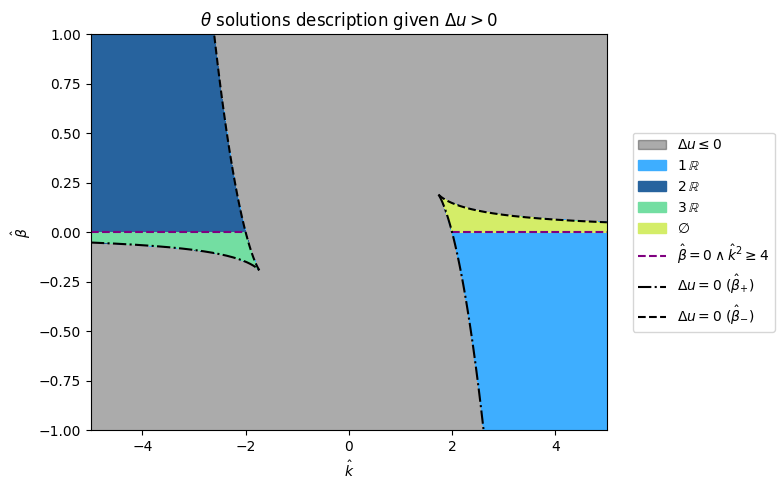

In [6]:
def deltau_greater_0(k,b):
    '''
    0 --> delta < 0
    1 --> Only One real solution
    2 --> Only Two Real solutions
    3 --> Three real solutions
    4 --> Not solutions
    '''
    d = delta(k, b)
    if d <= 0: return 0
    thetas = theta_values(k, b)
    if len(thetas) == 0: return 4
    assert np.isreal(thetas).all(), "All theta values should be real when delta > 0"
    count_unique = len(np.unique(thetas))
    return count_unique

min_k, max_k = -5, 5
min_b, max_b = -1, 1
n_points = 1000

k = np.linspace(min_k, max_k, n_points)
b = np.linspace(min_b, max_b, n_points)
K, B = np.meshgrid(k, b)
Z = np.vectorize(deltau_greater_0)(K, B)
levels = [-0.5, 0.5, 1.5, 2.5, 3.5, 4.5]
colors = ["#00000054", "#3eaeff", "#27639E", "#73DEA2", "#D4ED68"] 

norm = BoundaryNorm(levels, len(colors))

plt.figure(figsize=(8, 5))
contour = plt.contourf(K, B, Z, levels=levels, colors=colors, norm=norm, extend='both')
root = 2
line2, = plt.plot([min_k, -2], [0, 0], color="purple", linestyle='--', label=r"$\hat{\beta} = 0$")
line2, = plt.plot([2, max_k], [0, 0], color="purple", linestyle='--', label=r"$\hat{\beta} = 0 \wedge \hat{k}^2 \geq 4$")

# Compute beta(k) curves
beta_s_plus = beta_from_k_plus(k)
beta_s_minus = beta_from_k_minus(k)

# Split into contiguous NaN-free chunks and plot
segments_plus = split_on_nan(k, beta_s_plus)
segments_minus = split_on_nan(k, beta_s_minus)

legend_curves = [line2]

for i, (x_seg, y_seg) in enumerate(segments_plus):
    mask = (y_seg >= min_b) & (y_seg <= max_b)
    #zero_beta_mask = (x_seg > 0) & (y_seg >= 0)
    #y_seg[zero_beta_mask] = 0
    l, =plt.plot(x_seg[mask], y_seg[mask],
             color='black', linestyle='-.',
             label=r"$\Delta u = 0$ $(\hat{\beta}_{+})$" if i == 0 else "")
    if i==0: legend_curves.append(l)

for i, (x_seg, y_seg) in enumerate(segments_minus):
    mask = (y_seg >= min_b) & (y_seg <= max_b)
    #zero_beta_mask = x_seg > 0
    #y_seg[zero_beta_mask] = 0
    l, = plt.plot(x_seg[mask], y_seg[mask],
             color='black', linestyle='--',
             label=r"$\Delta u = 0$ $(\hat{\beta}_{-})$" if i == 0 else "")
    if i==0: legend_curves.append(l)

legend_labels = [r"$\Delta u \leq 0$",
                 r"$1\, \mathbb{R}$",                    # One real solution
                 r"$2\, \mathbb{R}$",                    # Two real solutions
                 r"$3\, \mathbb{R}$",                    # Three real solutions
                 r"$\varnothing$"]
legend_patches = [Patch(color=color, label=label) for color, label in zip(colors, legend_labels)] + legend_curves

plt.legend(handles=legend_patches,
           loc='center left',
           bbox_to_anchor=(1.05, 0.5),
           borderaxespad=0.)

plt.xlabel('$\\hat{k}$')
plt.ylabel('$\\hat{\\beta}$')
plt.title(r'$\theta$ solutions description given $\Delta u > 0$')
plt.tight_layout()
plt.savefig(os.path.join(base_folder, "Theta_solutions_description_Deltau_greater_0_vs_k_beta.png"), dpi=300)
plt.show()

Now we will focus on showing all the possible combinations given the boundaries in all $\Delta_u$ cases

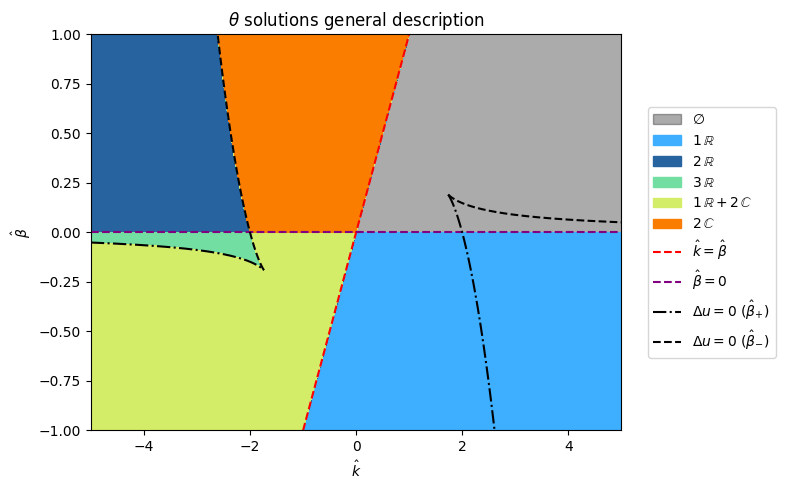

In [7]:
def deltau_greater_0(k,b):
    '''
    0 --> No solutions
    1 --> Only One real solution
    2 --> Only Two Real solutions
    3 --> Three real solutions
    4 --> One real and Two Complex solutions
    5 --> Only Two Complex solutions
    '''
    d = delta(k, b)
    thetas = theta_values(k, b)
    if len(thetas) == 0: return 0
    if d < 0:
        has_real = False
        has_complex = False
        for theta in thetas:
            if np.imag(theta) == 0:
                has_real = True
            else:
                has_complex = True
        if has_real and not has_complex:
            return 1
        if has_complex and not has_real:
            return 5
        if has_real and has_complex:
            return 4
    count_unique = len(np.unique(thetas))
    return count_unique

min_k, max_k = -5, 5
min_b, max_b = -1, 1
n_points = 1000

k = np.linspace(min_k, max_k, n_points)
b = np.linspace(min_b, max_b, n_points)
K, B = np.meshgrid(k, b)
Z = np.vectorize(deltau_greater_0)(K, B)
levels = [-0.5, 0.5, 1.5, 2.5, 3.5, 4.5, 5.5]
colors = ["#00000054", "#3eaeff", "#27639E", "#73DEA2", "#D4ED68","#FA7D00"] 

norm = BoundaryNorm(levels, len(colors))

plt.figure(figsize=(8, 5))
contour = plt.contourf(K, B, Z, levels=levels, colors=colors, norm=norm, extend='both')
root = 2
plot_min_k = max(min_k, min_b)
plot_max_k = min(max_k, max_b)
line1, = plt.plot([plot_min_k, plot_max_k], [plot_min_k, plot_max_k], color='red', linestyle='--', label=r"$\hat{k} = \hat{\beta}$")
line2, = plt.plot([min_k, max_k], [0, 0], color="purple", linestyle='--', label=r"$\hat{\beta} = 0$")

# Compute beta(k) curves
beta_s_plus = beta_from_k_plus(k)
beta_s_minus = beta_from_k_minus(k)

# Split into contiguous NaN-free chunks and plot
segments_plus = split_on_nan(k, beta_s_plus)
segments_minus = split_on_nan(k, beta_s_minus)

legend_curves = [line1, line2]

for i, (x_seg, y_seg) in enumerate(segments_plus):
    mask = (y_seg >= min_b) & (y_seg <= max_b)
    l, =plt.plot(x_seg[mask], y_seg[mask],
             color='black', linestyle='-.',
             label=r"$\Delta u = 0$ $(\hat{\beta}_{+})$" if i == 0 else "")
    if i==0: legend_curves.append(l)

for i, (x_seg, y_seg) in enumerate(segments_minus):
    mask = (y_seg >= min_b) & (y_seg <= max_b)
    l, = plt.plot(x_seg[mask], y_seg[mask],
             color='black', linestyle='--',
             label=r"$\Delta u = 0$ $(\hat{\beta}_{-})$" if i == 0 else "")
    if i==0: legend_curves.append(l)

legend_labels =  [
    r"$\varnothing$",                       # No solutions
    r"$1\, \mathbb{R}$",                    # One real solution
    r"$2\, \mathbb{R}$",                    # Two real solutions
    r"$3\, \mathbb{R}$",                    # Three real solutions
    r"$1\, \mathbb{R} + 2\, \mathbb{C}$",   # One real + two complex
    r"$2\, \mathbb{C}$"                     # Two complex solutions
]
legend_patches = [Patch(color=color, label=label) for color, label in zip(colors, legend_labels)] + legend_curves

plt.legend(handles=legend_patches,
           loc='center left',
           bbox_to_anchor=(1.05, 0.5),
           borderaxespad=0.)

plt.xlabel('$\\hat{k}$')
plt.ylabel('$\\hat{\\beta}$')
plt.title(r'$\theta$ solutions general description')
plt.tight_layout()
plt.savefig(os.path.join(base_folder, "Theta_solutions_description_all_Deltau.png"), dpi=300)
plt.show()